# Multi-class Conformal Prediction

In this notebook we will look at various methods for calibrating class probabilities in multi-class classification problems.


In [33]:
!pip install --upgrade venn-abers

!pip install catboost
!pip install dtype_diet

#install OpenML
!pip install openml

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import openml

import time

import plotly.io as pio
pio.renderers.default = 'colab'

# Set the style for visualization
sns.set_style("whitegrid")

from tqdm import tqdm

from dtype_diet import report_on_dataframe, optimize_dtypes

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

import gc
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, average_precision_score, recall_score, f1_score, roc_auc_score, log_loss, brier_score_loss
from sklearn.calibration import CalibrationDisplay, calibration_curve
from matplotlib.gridspec import GridSpec

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_predict

from catboost import CatBoostClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from venn_abers import VennAbersCalibrator

from scipy.io import arff

pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

In [35]:
# Check if CUDA (GPU support) is available
is_cuda_available = torch.cuda.is_available()

print(f"CUDA (GPU support) is available: {is_cuda_available}")

CUDA (GPU support) is available: False


## Load dataset

In [36]:
# List datasets https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

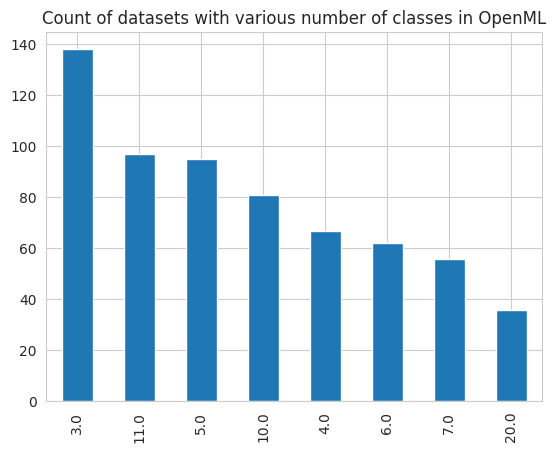

In [37]:
#plot number of datasets for each class size where class size is more than 2
datasets_df[datasets_df['NumberOfClasses'] > 2]['NumberOfClasses'].value_counts()[:20].plot(kind = 'bar')
plt.title('Count of datasets with various number of classes in OpenML')
plt.show()

In [38]:
# output information about selected dataset
datasets_df.loc[40900]

name                                  Satellite
version                                       1
uploader                                   3768
status                                   active
format                                     ARFF
MajorityClassSize                        5025.0
MaxNominalAttDistinctValues                 2.0
MinorityClassSize                          75.0
NumberOfClasses                             2.0
NumberOfFeatures                           37.0
NumberOfInstances                        5100.0
NumberOfInstancesWithMissingValues          0.0
NumberOfMissingValues                       0.0
NumberOfNumericFeatures                    36.0
NumberOfSymbolicFeatures                    1.0
Name: 40900, dtype: object

In [39]:
#  Satellite dataset https://www.openml.org/d/182
dataset = openml.datasets.get_dataset( 182)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'satimage', the target feature is 'class'
URL: https://api.openml.org/data/v1/download/3619/satimage.arff
**Author**: Ashwin Srinivasan, Department of Statistics and Data Modeling, University of Strathclyde  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+(Landsat+Satellite)) - 1993  
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)  

The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood. The aim is to predict this classifica


In [40]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [41]:
df.head()

,Aattr,Battr,Cattr,Dattr,Eattr,Fattr,A1attr,B2attr,C3attr,D4attr,E5attr,F6attr,A7attr,B8attr,C9attr,D10attr,E11attr,F12attr,A13attr,B14attr,C15attr,D16attr,E17attr,F18attr,A19attr,B20attr,C21attr,D22attr,E23attr,F24attr,A25attr,B26attr,C27attr,D28attr,E29attr,F30attr,class
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,0.670010,0.401020,0.052220,1.204523,1.181239,0.758245,-0.151111,1.214967,1.187378,0.598708,-0.136658,1.011130,0.899623,0.761977,-0.085593,1.211546,1.251179,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,0
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,-0.051291,-0.178503,-0.976988,-0.852379,-0.498640,0.124397,-0.668189,-0.836981,-0.487496,-0.084225,-0.656748,-0.343506,-0.176313,-0.234313,-0.748307,-0.981173,-0.614884,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,4
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,-0.712483,-0.441923,0.713854,0.504301,-0.198662,-0.403809,0.735308,0.341798,-0.188412,-0.399425,0.160536,-0.343506,-0.355636,-0.181877,0.650756,-0.016376,-0.915862,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,5
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,0.910444,0.401020,1.375487,0.810648,0.941256,0.230039,1.104649,1.214967,0.409758,0.230975,1.126416,1.011130,0.720300,0.237614,1.387105,0.860711,0.528832,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,2
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,-0.111399,0.190284,-1.197532,-1.202490,-0.138666,0.388501,-0.668189,-1.186248,-0.367863,0.230975,-0.879643,-0.998975,-0.355636,-0.129441,-0.895577,-1.244299,-0.795470,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,4


In [42]:
df['class'].value_counts()

0    1531
5    1508
2    1356
4     707
1     703
3     625
Name: class, dtype: int64

In [43]:
df.describe()

,Aattr,Battr,Cattr,Dattr,Eattr,Fattr,A1attr,B2attr,C3attr,D4attr,E5attr,F6attr,A7attr,B8attr,C9attr,D10attr,E11attr,F12attr,A13attr,B14attr,C15attr,D16attr,E17attr,F18attr,A19attr,B20attr,C21attr,D22attr,E23attr,F24attr,A25attr,B26attr,C27attr,D28attr,E29attr,F30attr,class
count,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000
mean,-0.000846,-0.000748,-0.000603,-0.000272,-0.000863,-0.000787,-0.000611,-0.000333,-0.000767,-0.000779,-0.000540,-0.000279,-0.000829,-0.000760,-0.000536,-0.000294,-0.000698,-0.000768,-0.000467,-0.000204,-0.000599,-0.000732,-0.000579,-0.000274,-0.000598,-0.000710,-0.000430,-0.000178,-0.000626,-0.000717,-0.000525,-0.000212,-0.000596,-0.000666,-0.000469,-0.000126,2.435148
std,0.999649,0.999944,0.999965,1.000196,0.999696,0.999958,0.999968,1.000220,0.999807,0.999904,0.999959,1.000203,0.999639,0.999957,1.000093,1.000232,0.999876,0.999964,1.000127,1.000264,1.000002,0.999981,1.000074,1.000218,1.000037,1.000000,1.000192,1.000271,0.999897,1.000022,1.000017,1.000271,0.999878,1.000013,1.000009,1.000288,1.876348
min,-2.234329,-2.473310,-2.780894,-2.624275,-2.223275,-2.457498,-2.947095,-2.824420,-2.146330,-2.444776,-2.936494,-2.812701,-2.226740,-2.471642,-2.958463,-2.833559,-2.145554,-2.452344,-2.939991,-2.815957,-2.217016,-2.441006,-2.925927,-2.803693,-2.221005,-2.472222,-2.962511,-2.825539,-2.219281,-2.457440,-2.940074,-2.815531,-2.218211,-2.448131,-2.930494,-2.808050,0.000000
25%,-0.690878,-0.550421,-0.858503,-0.719279,-0.674739,-0.534967,-0.846770,-0.712591,-0.661615,-0.520206,-0.832700,-0.758027,-0.682928,-0.546032,-0.858614,-0.720733,-0.668189,-0.531371,-0.846398,-0.714624,-0.656748,-0.518297,-0.833829,-0.758677,-0.674672,-0.542629,-0.855666,-0.719309,-0.662882,-0.531602,-0.844805,-0.715095,-0.651234,-0.519740,-0.834119,-0.761265,1.000000
50%,-0.102897,0.148811,0.102692,-0.084280,-0.084821,0.076748,0.113379,-0.079042,-0.141965,0.092157,0.068926,-0.073135,-0.094810,0.066663,0.101317,-0.086885,-0.077243,0.079847,0.050856,-0.084225,-0.136658,0.049776,0.062784,-0.077004,-0.085593,0.071332,0.047268,-0.087440,-0.069968,0.081165,0.053167,-0.084964,-0.128909,0.050011,0.064327,-0.079004,2.000000
75%,0.779075,0.848043,0.823588,0.497802,0.800057,0.863238,0.833490,0.501711,0.748864,0.835741,0.850335,0.506388,0.787369,0.854412,0.821265,0.494142,0.735308,0.865700,0.828476,0.493642,0.754923,0.880036,0.839849,0.499795,0.724391,0.860711,0.829810,0.491773,0.745289,0.869008,0.831409,0.492656,0.766507,0.838898,0.842981,0.498294,4.000000
max,2.543020,2.333912,2.445605,3.778629,2.569812,2.348830,2.753787,3.933434,2.604758,2.060467,2.773804,3.930845,2.551725,2.342384,2.741127,3.769022,2.582013,2.044478,2.742619,3.908307,2.612386,2.059880,2.752623,3.908156,2.565264,2.088634,2.455091,3.756429,2.598145,2.050772,2.747083,3.905865,2.631955,2.066056,2.759666,3.909603,5.000000


In [44]:
# print number of classes
n_classes = df['class'].nunique()
print('Number of classes: {}'.format(n_classes))

Number of classes: 6


In [45]:
# print number of classes
classes = np.sort(df['class'].unique())

In [46]:
classes

array([0, 1, 2, 3, 4, 5])

## Experiments

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Aattr    6430 non-null   float32
 1   Battr    6430 non-null   float32
 2   Cattr    6430 non-null   float32
 3   Dattr    6430 non-null   float32
 4   Eattr    6430 non-null   float32
 5   Fattr    6430 non-null   float32
 6   A1attr   6430 non-null   float32
 7   B2attr   6430 non-null   float32
 8   C3attr   6430 non-null   float32
 9   D4attr   6430 non-null   float32
 10  E5attr   6430 non-null   float32
 11  F6attr   6430 non-null   float32
 12  A7attr   6430 non-null   float32
 13  B8attr   6430 non-null   float32
 14  C9attr   6430 non-null   float32
 15  D10attr  6430 non-null   float32
 16  E11attr  6430 non-null   float32
 17  F12attr  6430 non-null   float32
 18  A13attr  6430 non-null   float32
 19  B14attr  6430 non-null   float32
 20  C15attr  6430 non-null   float32
 21  D16attr  6430 

In [48]:
print(f'Original df memory: {df.memory_usage(deep=True).sum()/1024/1024} MB')
proposed_df = report_on_dataframe(df, unit="MB")

df = optimize_dtypes(df, proposed_df)
print(f'Proposed df memory: {df.memory_usage(deep=True).sum()/1024/1024} MB')

Original df memory: 0.9322052001953125 MB
Proposed df memory: 0.8892803192138672 MB


In [49]:
df_train_cal, df_test = train_test_split(df, test_size = 500, random_state = 42, shuffle = True)
df_proper_train, df_cal = train_test_split(df_train_cal, test_size = 500, random_state = 42, shuffle = True)

In [50]:
print('Proper training set size: {}'.format(len(df_proper_train)))
print('Calibration set size: {}'.format(len(df_cal)))
print('Test set size: {}'.format(len(df_test)))

Proper training set size: 5430
Calibration set size: 500
Test set size: 500


In [51]:
X_train = df_train_cal.drop('class', axis=1)
y_train = df_train_cal['class']

X_proper_train = df_proper_train.drop('class', axis=1)
y_proper_train = df_proper_train['class']

X_cal = df_cal.drop('class', axis=1)
y_cal = df_cal['class']

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']

In [52]:
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)

In [53]:
y_test_binary

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

In [54]:
def brier_loss_calc(y_true, prob):
    return ((y_true - prob)**2).mean()

This code illustrates the multi-class Venn-ABERS calibration as implemented in "Multi-class probabilistic classification using inductive and cross Venn–Abers predictors." (Manokhin, Valery) In Conformal and Probabilistic Prediction and Applications, pp. 228-240. PMLR, 2017.

In [55]:
# Creating a dataframe to record the performance of various models
model_names = ['Naive Bayes', 'Logistic Regression', 'Random Forest Classifier', 'AdaBoost Classifier', 'CatBoost Classifier', 'SVC', 'LGBM Classifier', 'XGBoost Classifier']

methods = ['uncalibrated',	'Platt',	'Isotonic',	'Platt-CV',	'Isotonic-CV',	'IVAP',	'CVAP']

accuracy_df = pd.DataFrame(index=model_names, columns=methods)

# setup dataframes to store results for the Brier and the Log loss
brier_loss_df = accuracy_df.copy()
log_loss_df = accuracy_df.copy()

# Create a DataFrame to record execution times
time_df = pd.DataFrame(index=model_names, columns=['Execution Time (s)'])

In [56]:
RANDOM_STATE = 42

In [57]:
def evaluate_model_performance(model, model_name):

  start_time = time.time()  # Record start time
  model.fit(X_train, y_train)

  # Predict class score on the test set
  p_pred = model.predict_proba(X_test)
  # Predict on the test set
  y_pred = model.predict(X_test)

  # compute results of the underlying classifier
  accuracy_df.loc[model_name, 'uncalibrated'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'uncalibrated'] = log_loss(y_test, p_pred)
  brier_loss_df.loc[model_name, 'uncalibrated'] = brier_loss_calc(y_test_binary, p_pred)

  # compute results for Platt calibrator
  model.fit(X_proper_train, y_proper_train)
  cal_sigm = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
  cal_sigm.fit(X_cal, y_cal)

  #compute class and probability of predicted class
  p_pred = cal_sigm.predict_proba(X_test)
  y_pred = cal_sigm.predict(X_test)

  accuracy_df.loc[model_name, 'Platt'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'Platt'] = log_loss(y_test, p_pred)
  brier_loss_df.loc[model_name, 'Platt'] = brier_loss_calc(y_test_binary, p_pred)

  # compute results for Isotonic regression calibrator
  cal_iso = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
  cal_iso.fit(X_cal, y_cal)
  p_pred = cal_iso.predict_proba(X_test)
  y_pred = cal_iso.predict(X_test)

  accuracy_df.loc[model_name, 'Isotonic'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'Isotonic'] = log_loss(y_test, p_pred)
  brier_loss_df.loc[model_name, 'Isotonic'] = brier_loss_calc(y_test_binary, p_pred)

  # compute results for Platt-CV calibrator
  cal_sigm_cv = CalibratedClassifierCV(model, method='sigmoid', cv=5)
  cal_sigm_cv.fit(X_train, y_train)

  #compute class and probability of predicted class
  p_pred = cal_sigm_cv.predict_proba(X_test)
  y_pred = cal_sigm_cv.predict(X_test)

  accuracy_df.loc[model_name, 'Platt-CV'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'Platt-CV'] = log_loss(y_test, p_pred)
  brier_loss_df.loc[model_name, 'Platt-CV'] = brier_loss_calc(y_test_binary, p_pred)

  # compute results for Isotonic-CV calibrator
  cal_iso_cv = CalibratedClassifierCV(model, method='isotonic', cv=5)
  cal_iso_cv.fit(X_train, y_train)
  p_pred = cal_iso_cv.predict_proba(X_test)
  y_pred = cal_iso_cv.predict(X_test)

  accuracy_df.loc[model_name, 'Isotonic-CV'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'Isotonic-CV'] = log_loss(y_test, p_pred)
  brier_loss_df.loc[model_name, 'Isotonic-CV'] = brier_loss_calc(y_test_binary, p_pred)

  # compute results for IVAP calibrator
  va = VennAbersCalibrator(model, inductive=True, cal_size=500, random_state=RANDOM_STATE)
  va.fit(np.asarray(X_train), np.asarray(y_train))

  p_pred_va = va.predict_proba(np.array(X_test))
  y_pred = np.argmax(va.predict(X_test), axis=1)

  accuracy_df.loc[model_name, 'IVAP'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'IVAP'] = log_loss(y_test, p_pred_va)
  brier_loss_df.loc[model_name, 'IVAP'] = brier_loss_calc(y_test_binary, p_pred_va)

  # compute results for CVAP calibrator
  va_cv = VennAbersCalibrator(model, inductive=False, n_splits=5)
  va_cv.fit(np.asarray(X_train), np.asarray(y_train))
  p_pred_cv = va_cv.predict_proba(np.asarray(X_test))
  y_pred =  np.argmax(va_cv.predict(X_test), axis=1)

  accuracy_df.loc[model_name, 'CVAP'] = accuracy_score(y_test, y_pred)
  log_loss_df.loc[model_name, 'CVAP'] = log_loss(y_test, p_pred_cv)
  brier_loss_df.loc[model_name, 'CVAP'] = brier_loss_calc(y_test_binary, p_pred_cv)

  end_time = time.time()  # Record end time
  execution_time = end_time - start_time  # Calculate execution time in seconds

  # Record execution time in the time DataFrame
  time_df.loc[model_name, 'Execution Time (s)'] = execution_time


In [58]:
models = [
    GaussianNB(),
    LogisticRegression(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    AdaBoostClassifier(),
    CatBoostClassifier(task_type="GPU" if is_cuda_available else "CPU",
                       thread_count=-1, verbose=0, random_state=RANDOM_STATE),
    SVC(probability=True),
    LGBMClassifier(device='gpu' if is_cuda_available else 'cpu',
                   random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    XGBClassifier(tree_method='gpu_hist' if is_cuda_available else 'auto',
                  n_jobs=-1, num_class=n_classes)
]

In [59]:
for model, model_name in zip(models, model_names):
    print(f'processing: {model_name}')
    evaluate_model_performance(model, model_name)


processing: Naive Bayes
processing: Logistic Regression
processing: Random Forest Classifier
processing: AdaBoost Classifier
processing: CatBoost Classifier
processing: SVC
processing: LGBM Classifier
processing: XGBoost Classifier


In [60]:
accuracy_df

,uncalibrated,Platt,Isotonic,Platt-CV,Isotonic-CV,IVAP,CVAP
Naive Bayes,0.804,0.806,0.826,0.806,0.822,0.834,0.83
Logistic Regression,0.858,0.802,0.836,0.8,0.81,0.878,0.882
Random Forest Classifier,0.91,0.906,0.904,0.914,0.904,0.9,0.904
AdaBoost Classifier,0.758,0.628,0.746,0.724,0.78,0.892,0.876
CatBoost Classifier,0.92,0.908,0.894,0.916,0.918,0.906,0.926
SVC,0.896,0.894,0.886,0.894,0.89,0.9,0.896
LGBM Classifier,0.93,0.922,0.918,0.924,0.93,0.884,0.918
XGBoost Classifier,0.916,0.918,0.906,0.924,0.924,0.894,0.91


In [61]:
log_loss_df

,uncalibrated,Platt,Isotonic,Platt-CV,Isotonic-CV,IVAP,CVAP
Naive Bayes,3.613003,0.748671,0.771357,0.733909,0.544072,0.455508,0.472773
Logistic Regression,0.330626,0.573444,0.676732,0.56213,0.486974,0.326944,0.353028
Random Forest Classifier,0.262673,0.285431,0.52146,0.244604,0.224666,0.274455,0.280479
AdaBoost Classifier,1.149778,1.016316,1.610103,0.947233,0.7691,0.301958,0.332863
CatBoost Classifier,0.212955,0.314463,0.562956,0.263331,0.208423,0.267735,0.272995
SVC,0.267848,0.352296,0.582236,0.315861,0.289229,0.261901,0.305008
LGBM Classifier,0.23341,0.317691,0.429046,0.276056,0.198108,0.268679,0.275074
XGBoost Classifier,0.257202,0.3323,0.440867,0.275185,0.209,0.267851,0.278991


In [62]:
brier_loss_df

,uncalibrated,Platt,Isotonic,Platt-CV,Isotonic-CV,IVAP,CVAP
Naive Bayes,0.062693,0.053826,0.046361,0.05356,0.043806,0.040992,0.041521
Logistic Regression,0.031796,0.048106,0.043621,0.04805,0.044531,0.030174,0.030698
Random Forest Classifier,0.023633,0.022965,0.024033,0.021033,0.021669,0.023952,0.023954
AdaBoost Classifier,0.095207,0.084701,0.073049,0.078731,0.065862,0.027373,0.028507
CatBoost Classifier,0.02027,0.023712,0.023066,0.021605,0.020099,0.022692,0.022404
SVC,0.025388,0.031599,0.029787,0.028589,0.027174,0.023962,0.025891
LGBM Classifier,0.019972,0.022485,0.021968,0.020342,0.018867,0.024562,0.022684
XGBoost Classifier,0.022222,0.024277,0.023507,0.020842,0.019788,0.023448,0.023331


In [63]:
time_df

,Execution Time (s)
Naive Bayes,3.891745
Logistic Regression,35.032923
Random Forest Classifier,57.76286
AdaBoost Classifier,40.594322
CatBoost Classifier,623.017915
SVC,40.488699
LGBM Classifier,38.485523
XGBoost Classifier,141.783125


In [64]:
accuracy_df.to_csv('accuracy.csv')
log_loss_df.to_csv('log_loss.csv')
brier_loss_df.to_csv('brier_loss.csv')
time_df.to_csv('time_cpu.csv')

### Mean Brier and log loss scores

Conformal Prediction methods, IVAP and CVAP calibrators achieve the best calibration as indicated by lower Brier score and log loss.

In [68]:
log_loss_df.mean().sort_values()

IVAP            0.303129
CVAP            0.321401
Isotonic-CV     0.366197
Platt-CV        0.452289
Platt           0.492576
Isotonic        0.699345
uncalibrated    0.790937
dtype: float64

In [69]:
brier_loss_df.mean().sort_values()

IVAP            0.027144
CVAP            0.027374
Isotonic-CV     0.032724
Isotonic        0.035674
Platt-CV        0.036594
uncalibrated    0.037648
Platt           0.038959
dtype: float64

In [70]:
accuracy_df.mean().sort_values(ascending=False)

CVAP            0.89275
IVAP            0.88600
uncalibrated    0.87400
Isotonic-CV     0.87225
Isotonic        0.86450
Platt-CV        0.86275
Platt           0.84800
dtype: float64